## Necessary Imports

In [564]:
from torchvision.datasets import MNIST,FashionMNIST
transform = transforms.Compose([
    transforms.ToTensor()
])
m_train = MNIST(root='data/', download=True, transform=transform)
m_test = MNIST(root = "./data", train = False, download = True, transform=transform)

In [565]:
import torch
from torchvision  import transforms, datasets
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score as sk_f1_score
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [566]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Some initial analysis about the data

In [567]:
print((m_train))
print((m_test))

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [568]:
len(m_train)

60000

In [569]:
len(m_test)

10000

Label: 5


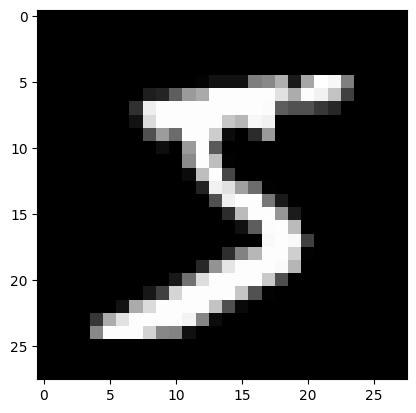

In [570]:
image, label = m_train[0]
plt.imshow(image.permute((1, 2, 0)), cmap='gray')
print('Label:', label)

## Data allocation

In [571]:
m_batch_size = 64

In [572]:
val_size = 10000
train_size = len(m_train) - val_size

m_train_ds, m_val_ds = random_split(m_train, [train_size, val_size])
len(m_train_ds), len(m_val_ds)

(50000, 10000)

In [573]:
m_train_ds

Label : 7


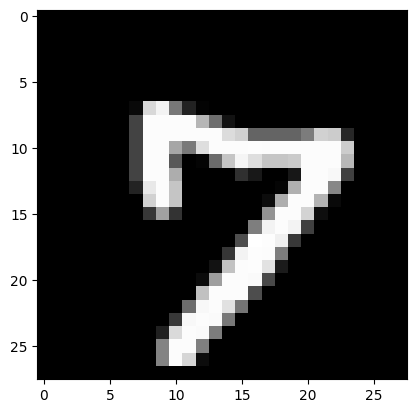

In [574]:
plt.imshow(m_train_ds[0][0].permute((1, 2, 0)),cmap='gray')
print(f"Label : {m_train_ds[0][1]}")

In [575]:
train_loader = DataLoader(m_train_ds, m_batch_size, shuffle=True)
val_loader = DataLoader(m_val_ds, m_batch_size)

In [576]:
for a,_ in train_loader:
    print(a.shape)
    break

torch.Size([64, 1, 28, 28])


images.shape: torch.Size([64, 1, 28, 28])


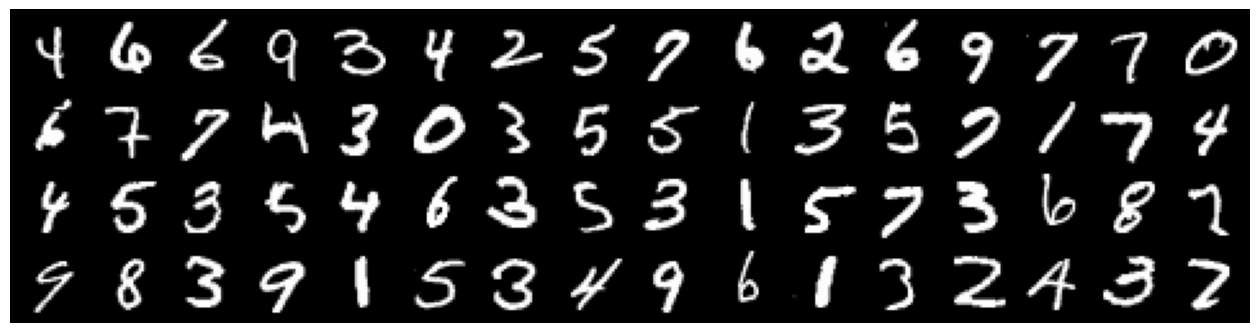

In [577]:
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## MNIST Model

In [578]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 30)
        self.linear2 = nn.Linear(30,20)
        self.linear3 = nn.Linear(20,10)
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out1 = self.linear1(xb)
        out1 = F.relu(out1)
        out2 = self.linear2(out1)
        out2 = F.relu(out2)
        out3 = self.linear3(out2)
        return out3

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)    # Calculate accuracy
        f1_sc = f1(out,labels)
        return {'val_loss': loss, 'val_acc': acc, 'val_f1':f1_sc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        batch_f1s =  [x['val_f1'] for x in outputs]
        epoch_f1 =torch.stack(batch_f1s).mean() 
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(),'val_f1':epoch_f1.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}, val_f1_score: {:.4f}".format(epoch, result['val_loss'], result['val_acc'],result['val_f1']))

In [579]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def f1(outputs, labels):

    _, preds = torch.max(outputs, dim=1)
    preds_np = preds.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Calculate F1 score (macro average for multi-class)
    f1 = sk_f1_score(labels_np, preds_np, average='macro')
    return torch.tensor(f1)

<font size=4> We'll create a model that contains a 2 hidden layers with 30 activations and 20 activations

In [580]:
model = MnistModel()
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
)

<font size=4>Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [581]:
for t in model.parameters():
    print(t.shape)

torch.Size([30, 784])
torch.Size([30])
torch.Size([20, 30])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])


<font size=4> Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [582]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3213610649108887
outputs.shape :  torch.Size([64, 10])
Sample outputs :
 tensor([[-0.1534,  0.1397,  0.0329,  0.1417, -0.1750, -0.1957,  0.0438,  0.2830,
         -0.0207,  0.1780],
        [-0.1513,  0.1011,  0.0495,  0.1035, -0.1351, -0.1498,  0.0291,  0.2653,
         -0.0167,  0.1849]])


In [583]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Training the model

<font size=4>Let's see how the model performs on the validation set with the initial set of weights and biases.

In [584]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.30884051322937,
  'val_acc': 0.10340366512537003,
  'val_f1': 0.018568331370546812}]

In [585]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2884, val_acc: 0.9146, val_f1_score: 0.9051
Epoch [1], val_loss: 0.2186, val_acc: 0.9359, val_f1_score: 0.9293
Epoch [2], val_loss: 0.2485, val_acc: 0.9189, val_f1_score: 0.9088
Epoch [3], val_loss: 0.1683, val_acc: 0.9493, val_f1_score: 0.9438
Epoch [4], val_loss: 0.1437, val_acc: 0.9591, val_f1_score: 0.9559
Epoch [5], val_loss: 0.1460, val_acc: 0.9557, val_f1_score: 0.9495
Epoch [6], val_loss: 0.1316, val_acc: 0.9617, val_f1_score: 0.9578
Epoch [7], val_loss: 0.1342, val_acc: 0.9605, val_f1_score: 0.9564
Epoch [8], val_loss: 0.1295, val_acc: 0.9622, val_f1_score: 0.9584


KeyboardInterrupt: 

<font size=4>96% is pretty good! Let's train the model for 10 more epochs at a lower learning rate of 0.01 to improve the accuracy further.

In [586]:
history += fit(10, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1257, val_acc: 0.9629, val_f1_score: 0.9588
Epoch [1], val_loss: 0.1235, val_acc: 0.9640, val_f1_score: 0.9601
Epoch [2], val_loss: 0.1219, val_acc: 0.9646, val_f1_score: 0.9608
Epoch [3], val_loss: 0.1208, val_acc: 0.9651, val_f1_score: 0.9614
Epoch [4], val_loss: 0.1199, val_acc: 0.9654, val_f1_score: 0.9617
Epoch [5], val_loss: 0.1192, val_acc: 0.9656, val_f1_score: 0.9619
Epoch [6], val_loss: 0.1186, val_acc: 0.9657, val_f1_score: 0.9620
Epoch [7], val_loss: 0.1181, val_acc: 0.9658, val_f1_score: 0.9622
Epoch [8], val_loss: 0.1177, val_acc: 0.9661, val_f1_score: 0.9625
Epoch [9], val_loss: 0.1173, val_acc: 0.9662, val_f1_score: 0.9628


In [587]:
history += fit(20, 0.00001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1172, val_acc: 0.9663, val_f1_score: 0.9629
Epoch [1], val_loss: 0.1172, val_acc: 0.9663, val_f1_score: 0.9629
Epoch [2], val_loss: 0.1172, val_acc: 0.9663, val_f1_score: 0.9629


KeyboardInterrupt: 

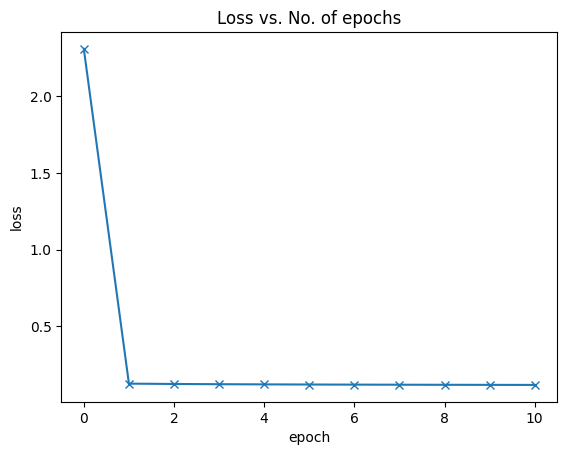

In [588]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

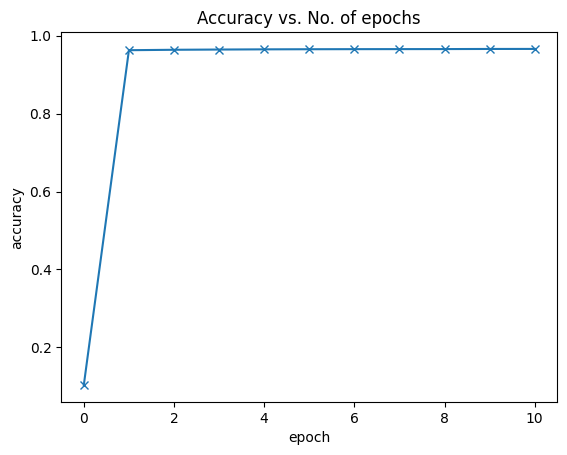

In [589]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [591]:
len(history)

11

## Results

In [592]:
def predict_image(test_dataset, model):
    pred = []
    label = []
    for i in range(len(test_dataset)):
        xb = test_dataset[i][0].unsqueeze(0)
        # print(type(xb))
        yb = model(xb)
        _, preds  = torch.max(yb, dim=1)
        pred.append(int(preds))
        label.append(int(test_dataset[i][1]))
    return pred,label
pred_mlp,gt_mlp = predict_image(m_test,model)
np.array([(pred_mlp),(gt_mlp)])

array([[7, 2, 1, ..., 4, 5, 6],
       [7, 2, 1, ..., 4, 5, 6]])

In [593]:
acc_mlp, f1_mlp = accuracy_score(gt_mlp,pred_mlp),sk_f1_score(gt_mlp,pred_mlp,average='weighted')
print(f"Final accuracy of the model = {acc_mlp},\nFinal f1_score of the model = {f1_mlp:.4f}")

Final accuracy of the model = 0.9673,
Final f1_score of the model = 0.9673


In [594]:
X_train = m_train.data.float()  
y_train = m_train.targets         

X_test = m_test.data.float()     
y_test = m_test.targets           

X_train = X_train.view(X_train.size(0), -1)  
X_test = X_test.view(X_test.size(0), -1)

## Comparison with different Models

In [595]:
def plot_confusion_matrix(y_true, y_pred, model_name, accuracy, f1):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

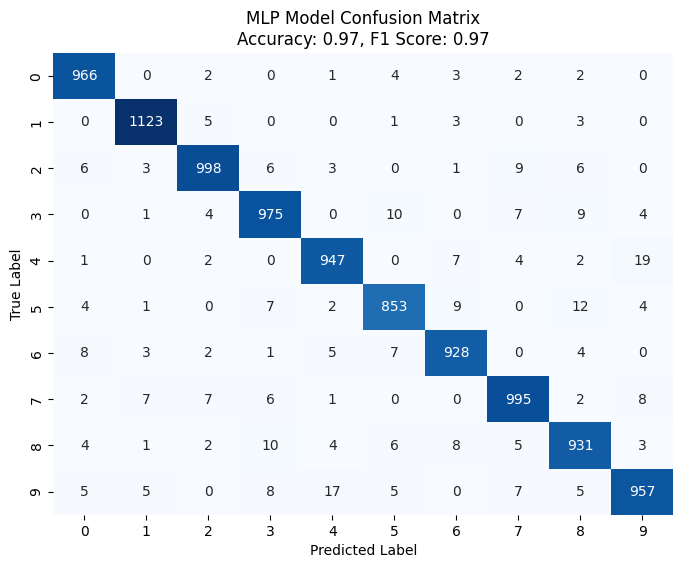

In [596]:
plot_confusion_matrix(y_test, pred_mlp, 'MLP Model', acc_mlp,f1_mlp)

C:\Users\LAKSHYA\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


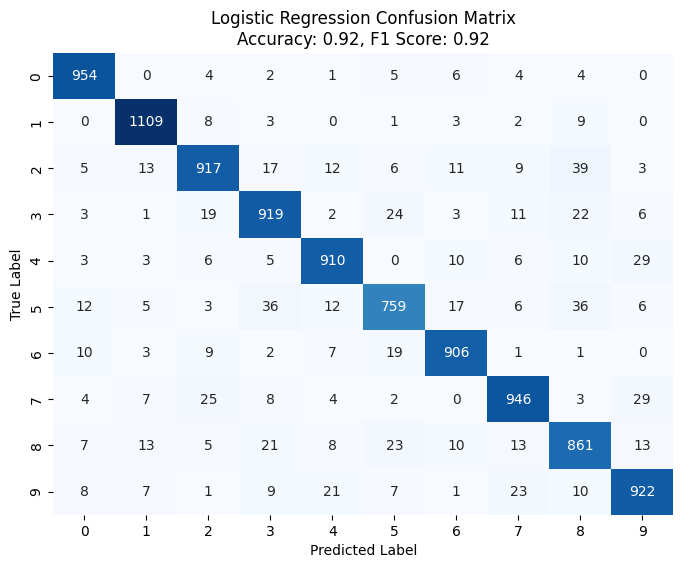

In [597]:
log_reg = LogisticRegression(max_iter = 1000, random_state = 42)
log_reg.fit(X_train, y_train)
log_predictions = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_predictions)
log_f1 = sk_f1_score(y_test, log_predictions, average = "weighted")

plot_confusion_matrix(y_test, log_predictions, 'Logistic Regression', log_accuracy, log_f1)

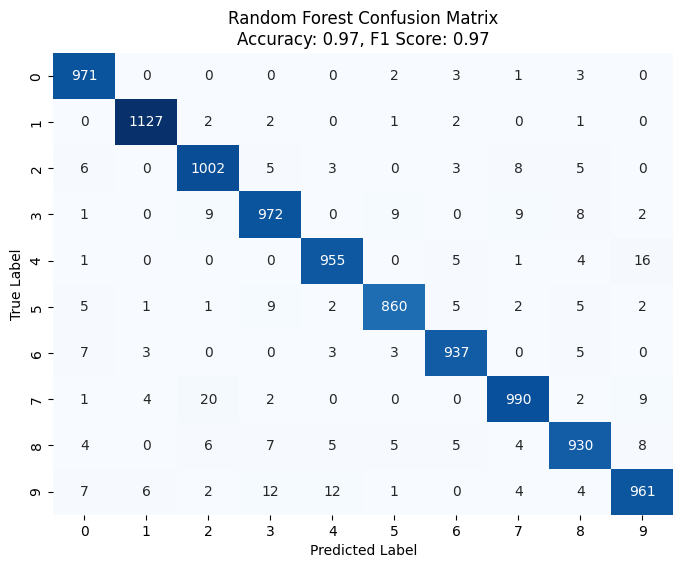

In [598]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_f1 = sk_f1_score(y_test, rf_predictions, average = "weighted")

plot_confusion_matrix(y_test, rf_predictions, 'Random Forest', rf_accuracy, rf_f1)

## T-SNE PLOT

In [599]:
def get_activations(model, dataloader):
    model.eval()  
    activations = []
    labels = []
    
    with torch.no_grad():  
        for images, lbl in dataloader:
            output_20_neurons = model(images) 
            activations.append(output_20_neurons)
            labels.append(lbl)

    return torch.cat(activations), torch.cat(labels)

In [600]:
train_loader = DataLoader(m_train,shuffle=True)
mnist_combined = torch.utils.data.ConcatDataset([m_train, m_test])
mnist_loader = DataLoader(mnist_combined, batch_size = len(mnist_combined), shuffle = False)

In [601]:
trained_activations, trained_labels = get_activations(model, train_loader)

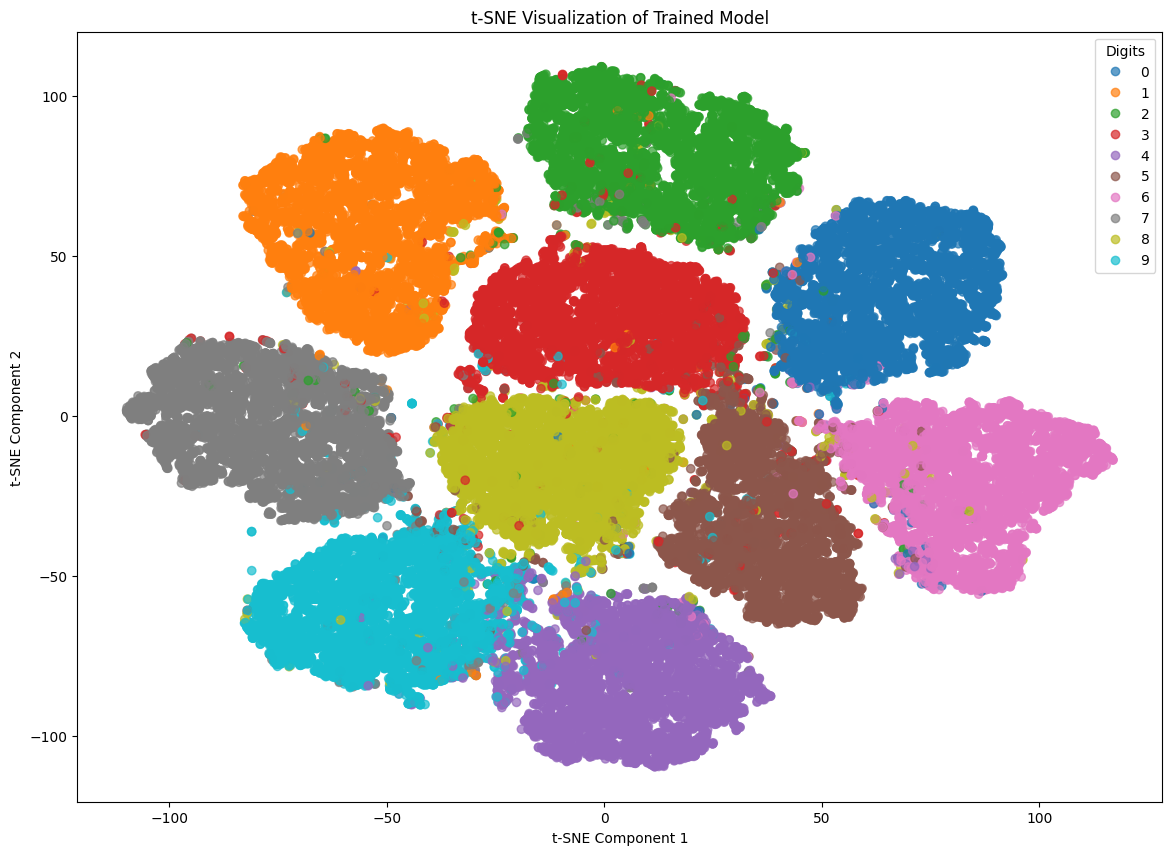

In [602]:
def plot_tsne(activations, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(activations)

    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Digits")
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

plot_tsne(trained_activations, trained_labels, "t-SNE Visualization of Trained Model")

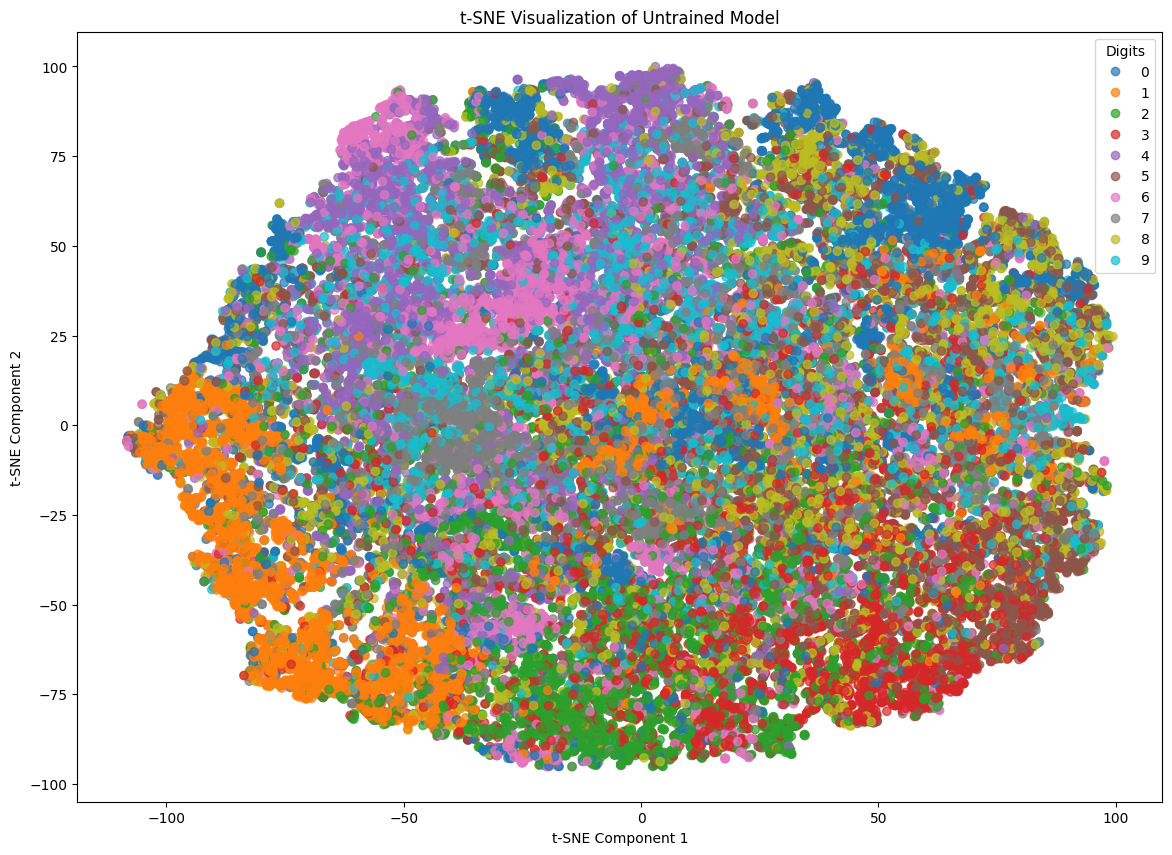

In [603]:
untrained_model = MnistModel()
untrained_activations, untrained_labels = get_activations(untrained_model, train_loader)
plot_tsne(untrained_activations, untrained_labels, "t-SNE Visualization of Untrained Model")

## Fashion MNIST

In [604]:
f_train = FashionMNIST(root='data/' , download=True,transform=transform)
f_test = FashionMNIST(root='data/',train = False , download=True,transform=transform)
fashion_combined = torch.utils.data.ConcatDataset([f_train, f_test])
fashion_loader = DataLoader(fashion_combined, batch_size = len(fashion_combined), shuffle = False)

In [608]:
def predict_image(test_dataset, model):
    pred = []
    label = []
    for i in range(len(test_dataset)):
        xb = test_dataset[i][0].unsqueeze(0)
        # print(type(xb))
        yb = model(xb)
        _, preds  = torch.max(yb, dim=1)
        pred.append(int(preds))
        label.append(int(test_dataset[i][1]))
    return pred,label
f_pred,f_gt = predict_image(fashion_combined,model)
np.array([f_pred,f_gt])

array([[2, 8, 8, ..., 5, 8, 2],
       [9, 0, 0, ..., 8, 1, 5]])

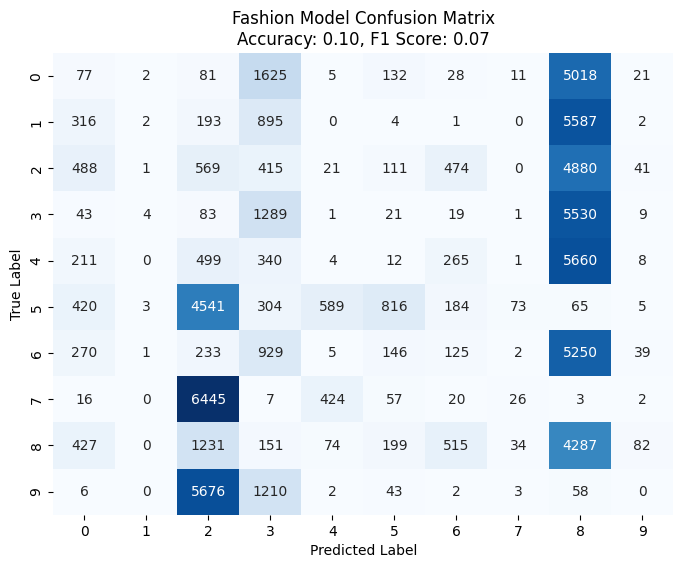

In [609]:
plot_confusion_matrix(f_gt, f_pred, 'Fashion Model', accuracy_score(f_gt,f_pred),sk_f1_score(f_gt,f_pred,average='weighted'))


In [607]:
trained_activations, trained_labels = get_activations(model, fashion_loader)

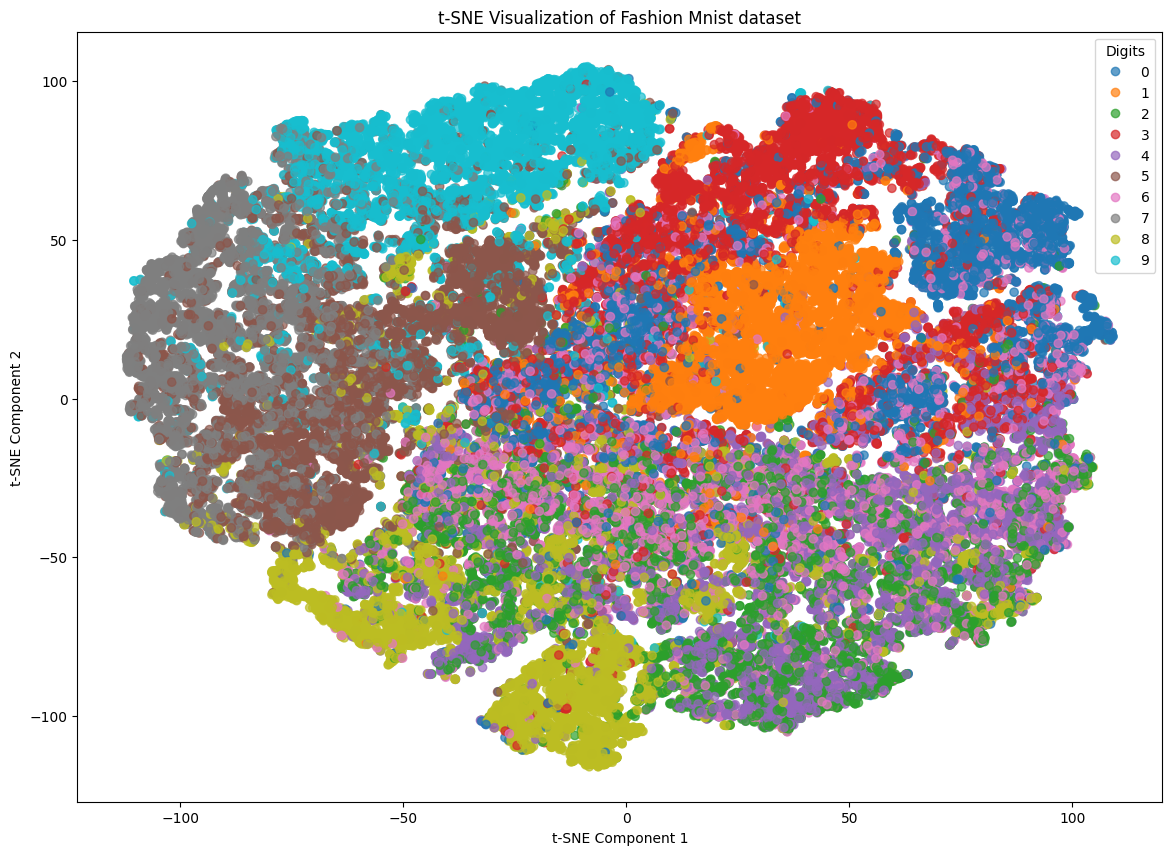

In [610]:
plot_tsne(trained_activations, trained_labels, "t-SNE Visualization of Fashion Mnist dataset")

In [526]:
f_mnist_labels = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [540]:
def predict_image(test_dataset, model):
    pred = []
    label = []
    for i in range(len(test_dataset)):
        xb = test_dataset[i][0].unsqueeze(0)
        # print(type(xb))
        yb = model(xb)
        _, preds  = torch.max(yb, dim=1)
        pred.append(int(preds))
        label.append(int(test_dataset[i][1]))
    return pred,label
pred_mlp,gt_mlp = predict_image(f_test,model)
np.array([(pred_mlp),(gt_mlp)])

array([[9, 2, 1, ..., 8, 1, 5],
       [9, 2, 1, ..., 8, 1, 5]])

In [542]:
acc_mlp, f1_mlp = accuracy_score(gt_mlp,pred_mlp),sk_f1_score(gt_mlp,pred_mlp,average='weighted')
print(f"Final accuracy of the model = {acc_mlp},\nFinal f1_score of the model = {f1_mlp:.4f}")

Final accuracy of the model = 0.873,
Final f1_score of the model = 0.8726


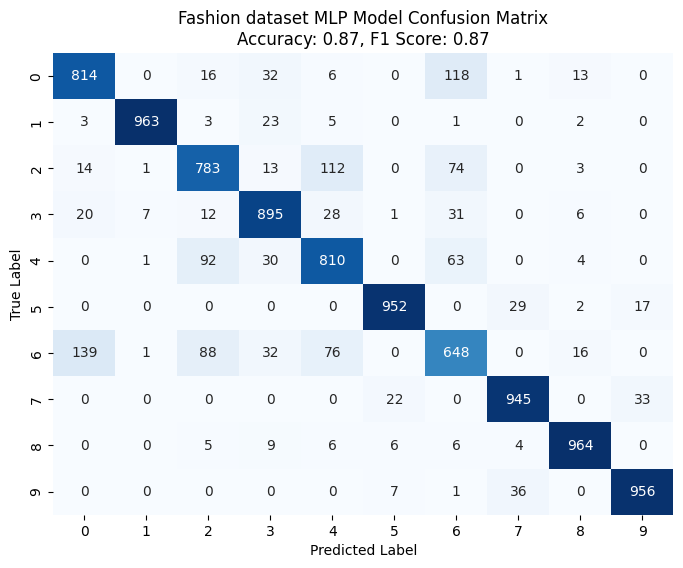

In [543]:
plot_confusion_matrix(y_test, pred_mlp, 'Fashion dataset MLP Model', acc_mlp,f1_mlp)

In [546]:
train_loader = DataLoader(f_train,shuffle=True)
trained_activations, trained_labels = get_activations(model, train_loader)

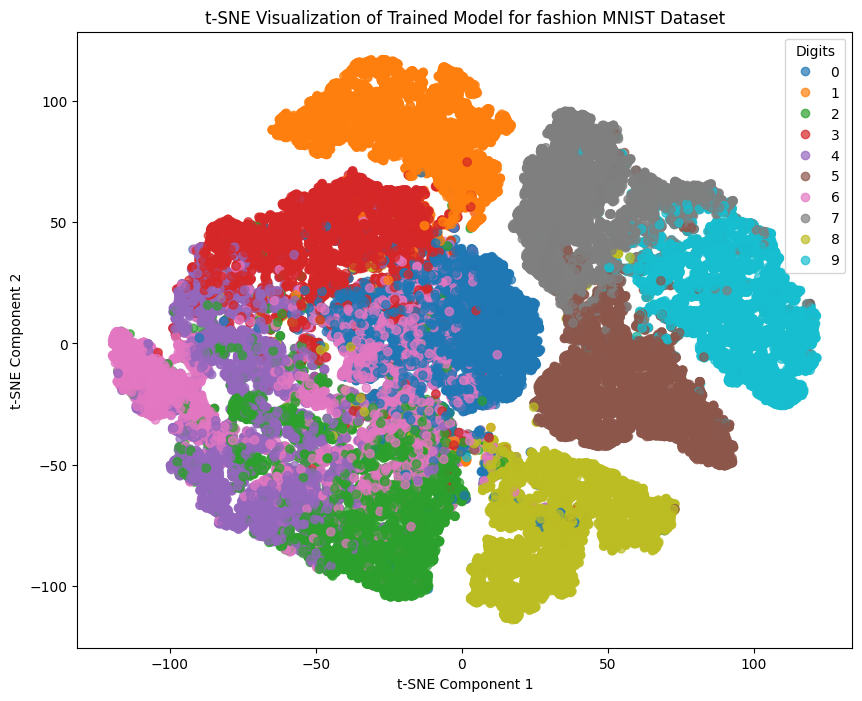

In [547]:
plot_tsne(trained_activations, trained_labels, "t-SNE Visualization of Trained Model for fashion MNIST Dataset")

Thanks.